In [24]:
import glob 
import numpy as np 
import os 
import shutil 
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator,  load_img, img_to_array, array_to_img 
np.random.seed(42) 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,recall_score

import matplotlib.pyplot as plt 

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
IM_SHAPE=(224,224)

In [4]:
filesCOV= glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/ALL/COVID-19/images/*')
filesNOCOV=glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/CompleteDataset/Lung Segmentation Data/Lung Segmentation Data/ALL/Normal/images/*')


In [5]:
COVID = [fn for fn in filesCOV if 'covid' in fn] 
HEALTHY = [fn for fn in filesNOCOV if 'sano' in fn] 

len(COVID), len(HEALTHY)


(11956, 10701)

In [6]:
COVID_train = np.random.choice(filesCOV, size=2000, replace=False) 
HEALTHY_train = np.random.choice(filesNOCOV, size=2000, replace=False) 
filesCOV = list(set(filesCOV) - set(COVID_train)) 
filesNOCOV = list(set(filesNOCOV) - set(HEALTHY_train)) 
 
COVID_val = np.random.choice(filesCOV, size=1000, replace=False) 
HEALTHY_val = np.random.choice(filesNOCOV, size=1000, replace=False) 
filesCOV = list(set(filesCOV) - set(COVID_val)) 
filesNOCOV = list(set(filesNOCOV) - set(HEALTHY_val)) 
 
#COVID_test = np.random.choice(filesCOV, size=1000, replace=False) 
#HEALTHY_test = np.random.choice(filesNOCOV, size=1000, replace=False) 
 
print('Cat datasets:', COVID_train.shape, COVID_val.shape) 
print('Dog datasets:', HEALTHY_train.shape, HEALTHY_val.shape) 

Cat datasets: (2000,) (1000,)
Dog datasets: (2000,) (1000,)


In [7]:
train_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/train' 
val_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/valid' 
#test_dir = 'C:/Users/hecto/Downloads/MachineCrypto/Proyecto/test' 
 
    
train_files = np.concatenate([COVID_train, HEALTHY_train]) 
validate_files = np.concatenate([COVID_val, HEALTHY_val]) 
#test_files = np.concatenate([COVID_test, HEALTHY_test])
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None 
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None 
#os.mkdir(test_dir) if not os.path.isdir(test_dir) else None 
 
for fn in train_files: 
    shutil.copy(fn, train_dir) 
for fn in validate_files: 
    shutil.copy(fn, val_dir) 
#for fn in test_files: 
#    shutil.copy(fn, test_dir) 
 

In [8]:
IMG_DIM = IM_SHAPE
 
train_files = glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/train/*') 
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img  
              in train_files] 
train_imgs = np.array(train_imgs) 
train_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                train_files] 

validation_files = glob.glob('C:/Users/hecto/Downloads/MachineCrypto/Proyecto/valid/*') 
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for 
                   img in validation_files] 
validation_imgs = np.array(validation_imgs) 
validation_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in 
                     validation_files] 
 
print('Train dataset shape:', train_imgs.shape,  
      'Validation dataset shape:', validation_imgs.shape) 

Train dataset shape: (4000, 150, 150, 3) Validation dataset shape: (2000, 150, 150, 3)


(150, 150, 3)


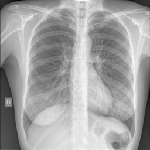

In [9]:
train_imgs_scaled = train_imgs.astype('float32') 
validation_imgs_scaled = validation_imgs.astype('float32') 
train_imgs_scaled /= 255 
validation_imgs_scaled /= 255 
 
# visualize a sample image 
print(train_imgs[0].shape) 
array_to_img(train_imgs[0]) 

In [10]:
for i in range(4000):
    if train_labels[i].find("sano")==-1:
        train_labels[i]='covid'
    else :
        train_labels[i]='sano'
for i in range(2000):
    if validation_labels[i].find("sano")==-1:
        validation_labels[i]='covid'
    else :
        validation_labels[i]='sano'
        

In [11]:
batch_size = 8
num_classes = 2 
epochs = 30 
input_shape = (IM_SHAPE[0],IM_SHAPE[1], 3) 
 
# encode text category labels 
from sklearn.preprocessing import LabelEncoder 
 
le = LabelEncoder() 
le.fit(train_labels) 
train_labels_enc = le.transform(train_labels) 
validation_labels_enc = le.transform(validation_labels) 
 
print(train_labels[190:195], train_labels_enc[195:200]) 

['covid', 'covid', 'covid', 'covid', 'covid'] [0 0 0 0 0]


In [12]:
input_shape

(150, 150, 3)

In [13]:
from keras.applications import MobileNet
from keras.models import Model 
import keras 
resnet=MobileNet(include_top=False,weights='imagenet',  
                                     input_shape=input_shape)

# we have removed the final part of the classifier pertaining to the VGG-16 model 
#since we will be building our own classifier and leveraging VGG as a feature extractor
output = resnet.layers[-1].output 
output = keras.layers.Flatten()(output) 
resnet_model = Model(resnet.input, output) 
resnet_model.trainable = False 
 
for layer in resnet_model.layers: 
    layer.trainable = False 

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 77, 77, 64)   0           ['conv1_conv[0][0]']         

 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 38, 38, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
          

 conv3_block2_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_out (Add)         (None, 19, 19, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_conv[0][0]']    
          

                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_pad (ZeroPaddin  (None, 12, 12, 256)  0          ['conv4_block1_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 10, 10, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_out (Add)         (None, 10, 10, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_conv[0][0]']    
                                                                                                  
 conv4_block4_preact_bn (BatchN  (None, 10, 10, 1024  4096       ['conv4_block3_out[0][0]']       
 ormalization)                  )                                                                 
          

                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_pad (ZeroPaddin  (None, 12, 12, 256)  0          ['conv4_block6_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 5, 5, 256)    589824      ['conv4_block6_2_pad[0][0]']     
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 5, 5, 256)   1024        ['conv4_block6_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv5_block2_out (Add)         (None, 5, 5, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
                                                                                                  
 conv5_block3_preact_bn (BatchN  (None, 5, 5, 2048)  8192        ['conv5_block2_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv5_block3_preact_relu (Acti  (None, 5, 5, 2048)  0           ['conv5_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv5_blo

In [14]:
# To verify that the layers of the VGG-16 model are frozen, we can use the following code:
import pandas as pd 
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in 
           resnet_model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\hecto\AppData\Local\Temp\ipykernel_18400\3903062396.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001B3D13D6130>,input_1,False
1,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001B3D13B6E20>,conv1_pad,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B2CFD1A8B0>,conv1_conv,False
3,<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001B2C7FCB640>,pool1_pad,False
4,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001B3D1470C10>,pool1_pool,False
...,...,...,...
186,<keras.layers.convolutional.conv2d.Conv2D object at 0x000001B3D8A5CDC0>,conv5_block3_3_conv,False
187,<keras.layers.merging.add.Add object at 0x000001B3D8A523A0>,conv5_block3_out,False
188,<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001B3D8A447C0>,post_bn,False
189,<keras.layers.core.activation.Activation object at 0x000001B3D8A31310>,post_relu,False


In [15]:
print("Trainable layers:", resnet_model.trainable_weights)


Trainable layers: []


1/1 [==============================] - 3s 3s/step
(1, 5, 5, 2048)


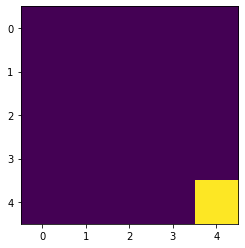

In [16]:
bottleneck_feature_example = resnet.predict(train_imgs_scaled[0:1])
print(bottleneck_feature_example.shape) 
plt.imshow(bottleneck_feature_example[0][:,:,0]) 

In [17]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib

device_lib.list_local_devices()

tf.test.is_built_with_cuda()

tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1


In [18]:
def get_bottleneck_features(model, input_imgs): 
    features = model.predict(input_imgs, verbose=0) 
    return features 

train_features_resnet = get_bottleneck_features(resnet_model, 
                                             train_imgs_scaled) 
validation_features_resnet= get_bottleneck_features(resnet_model,      
                                                validation_imgs_scaled) 

print('Train Bottleneck Features:', train_features_resnet.shape, 
      '\tValidation Bottleneck Features:', validation_features_resnet.shape) 

Train Bottleneck Features: (4000, 51200) 	Validation Bottleneck Features: (2000, 51200)


In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier

In [20]:
X_train=train_features_resnet
y_train=train_labels_enc
X_valid=validation_features_resnet
y_valid=validation_labels_enc


In [ ]:
hist=BaggingClassifier(
base_estimator=DecisionTreeClassifier(),
n_estimators=5
)
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

In [25]:
hist=RandomForestClassifier(n_estimators=5)
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[[828 172]
 [152 848]]
Accuracy:  0.838
Recall:  0.848
Precision:  0.8313725490196079
F1-score:  0.8396039603960396


In [26]:
hist=XGBClassifier()
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[[943  57]
 [ 85 915]]
Accuracy:  0.929
Recall:  0.915
Precision:  0.941358024691358
F1-score:  0.9279918864097363


In [ ]:
hist=LGBMClassifier(n_estimators=1000,class_weight='balanced',
                                       reg_alpha=0.1,reg_lambda=0.1,
                                       learning_rate=0.001,num_leaves=400,boosting='dart'
)
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart


In [ ]:
hist=AdaBoostClassifier(
base_estimator=DecisionTreeClassifier(),
n_estimators=300
)
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))

In [ ]:
hist=DecisionTreeClassifier()
hist.fit(X_train,y_train)
cm2 = confusion_matrix(y_valid,hist.predict(X_valid))
print(cm2)
acc=accuracy_score(y_valid, hist.predict(X_valid))
print("Accuracy: ",(acc))
recall=recall_score(y_valid, hist.predict(X_valid))
print("Recall: ",(recall))
prec=precision_score(y_valid,hist.predict(X_valid))
print("Precision: ",(prec))
f1=f1_score(y_valid,hist.predict(X_valid))
print("F1-score: ",(f1))